[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 16, 16, 16, 45, 45, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 65, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

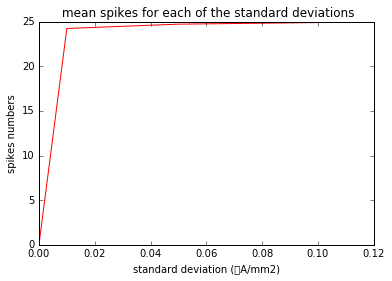

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def CST(I, dt):
    ##########################################################################
    # Simulate the membrane potential of a CST neuron with 
    #   a given input current
    # Input:
    #    I = current in uA/mm^2a
    #    dt = time step between I measurments [ms]
    #
    # Output:
    #    Vm = membrane voltage in mV
    #    n = sodium activation
    #    m = potassium activation
    #    h = 1 - potassium inactivation
    
    # This function simulates a dynamical system with state variables
    #    DV = 1/C (I - Ik - Ina - Il)
    #    Il = gl(V-El)
    #    Ik = gk*n^4(V-Ek)
    #    Ina = gna*m^3*h(V-Ena)
    #    IA=gA*a^3*b(V-EA)
    #    Dn = (ninf(V) - n)/taun(V) (same for m, h,a,b )

    # Summary of units: I = uA / mm^2; V = mV; g = mS; g*V = uA; C = uF; uA/uC*ms = mV

    ##########################################################################
    # Constants:
    # Reversal potentials for various ions
    Ek = -72 #[mV]
    Ena = 55 #[mV]
    El = -17 #[mV]
    EA = -75 #[mV] 
    
    # Membrane capacitance: 
    C = 0.01 #[uF/mm^2]
    
    # Maximum conductances [mS/mm^2]
    gna = 1.2
    gk = 0.2
    gl = 0.003
    gA = 0.477
    
    ##########################################################################
    # Gating variables:
    # activation K [n]
    alpha_m = lambda V: 0.38*(V + 29.7) / (1 - np.exp(-0.1*(V + 29.7)))
    beta_m = lambda V: 15.2 * np.exp(-0.0556*(V + 54.7))
    tau_m = lambda V: 1/(alpha_m(V) + beta_m(V))
    m_inf = lambda V: alpha_m(V) * tau_m(V)

    alpha_h = lambda V: 0.266*np.exp(-0.05*(V + 48))
    beta_h = lambda V:  3.8 /(1 + np.exp(-0.1*(V + 18)))
    tau_h = lambda V: 1/(alpha_h(V) + beta_h(V))
    h_inf = lambda V: alpha_h(V) * tau_h(V);

    alpha_n = lambda V: 0.02*(V + 45.7) / (1 - np.exp(-0.1*(V + 45.7)))
    beta_n = lambda V: 0.25 * np.exp(-0.0125*(V + 55.7))
    tau_n = lambda V: 1 /(alpha_n(V) + beta_n(V))
    n_inf = lambda V: alpha_n(V) * tau_n(V)

    a_inf = lambda V: ((0.0761*np.exp(0.0314*(V+94.22)))/(1 + np.exp(0.0346*(V+1.17))))**(1/3)
    b_inf = lambda V: 1/(1 + np.exp(0.0688*(V+53.3)))**4
    tau_a = lambda V: 0.3632 + 1.158/(1 + np.exp(0.0497*(V + 55.96)))
    tau_b = lambda V: 1.24 + 2.678/(1 + np.exp(0.0624*(V + 50)))
    
    # Initializations
    n = np.zeros(len(I)); m = np.zeros(len(I)); h = np.zeros(len(I));
    a = np.zeros(len(I)); b = np.zeros(len(I));
    V = np.zeros(len(I))
 
    # Set initial conditions:
    Vstart = -68 #[mV] (starting membrane potential) 
    V[0] = Vstart #[mV]
    n[0] = n_inf(Vstart); m[0] = m_inf(Vstart); h[0] = h_inf(Vstart);
    a[0] = a_inf(Vstart); b[0] = b_inf(Vstart);
    ##########################################################################
    # Simulation: iteratatively update the variables using the forward Euler method
    for i in range(len(I)-1):
        n[i+1] = n[i] + dt*(n_inf(V[i]) - n[i])/tau_n(V[i])
        m[i+1] = m[i] + dt*(m_inf(V[i]) - m[i])/tau_m(V[i])
        h[i+1] = h[i] + dt*(h_inf(V[i]) - h[i])/tau_h(V[i])
        a[i+1] = a[i] + dt*(a_inf(V[i]) - a[i])/tau_a(V[i])
        b[i+1] = b[i] + dt*(b_inf(V[i]) - b[i])/tau_b(V[i])
        V[i+1] = V[i] + dt/C*(I[i] - gl*(V[i] - El) - gk*n[i]**4*(V[i] - Ek)-
                              gna*m[i]**3*h[i]*(V[i] - Ena) - gA*a[i]**3*b[i]*(V[i] - EA))

    return V, m, n, h, a, b
def get_aps(V):
    V_ap=[]
    for i in range(len(V)-1):
        if V[i]>0:
            V_ap.append(V[i])
    ap=0
    for i in range(len(V_ap)-1):
        if V_ap[i+1]-V_ap[i]>=0 and V_ap[i+2]-V_ap[i+1]<=0:
            ap +=1
    return ap
u=[0,0.05,0.1,0.15,0.2]
sigma=[0,0.01,0.05,0.1]

spikes=[]
mean_spikes=np.zeros(4)
dt=0.01
I = np.zeros(int(600/dt))
for i in range(len(sigma)):
    for j in range(len(u)):
        if sigma[i]==0:
            s_0=0
            a = sigma[i]*np.random.randn(50000)+u[j]
            d = np.ones(100)
            c = np.convolve(a,d, "same")/sum(d)
            I[int((50)/dt):int((500+50)/dt)]=c
            V,m,n,h,a,b=CST(I,dt)
            s_o=get_aps(V)
            spikes.append(s_0)
        else:
            for l in range(25):
                s=0
                a = sigma[i]*np.random.randn(50000)+u[j]
                d = np.ones(100)
                c = np.convolve(a,d, "same")/sum(d)
                I[int((50)/dt):int((500+50)/dt)]=c
                V,m,n,h,a,b=CST(I,dt)
                s=get_aps(V)
                spikes.append(s)
    mean_spikes[i]=np.mean(spikes)

print(spikes)
print(len(spikes))
print(mean_spikes)

%matplotlib inline
fig,ax1=plt.subplots()
ax1.plot(sigma,mean_spikes,'r')
ax1.set_title(' mean spikes for each of the standard deviations')
ax1.set_xlabel('standard deviation (μA/mm2)')
ax1.set_ylabel('spikes numbers')